# Kinetics - Water-Gas-Shift Mechanism

```
Created for ME 4443 @ LSU (Spring 2018)
```

In [1]:
# modules used
import cantera as ct
import numpy as np
import graphviz
import os

import matplotlib.pyplot as plt
%matplotlib notebook

## Analyze 'Reaction' within Full Mechanism

In [2]:
gas = ct.Solution('gri30.xml')

In [3]:
gas.n_species, gas.n_reactions

(53, 325)

In [4]:
print('Species in full mechanisms:')
print(gas.species_names)

Species in full mechanisms:
['H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2', 'C', 'CH', 'CH2', 'CH2(S)', 'CH3', 'CH4', 'CO', 'CO2', 'HCO', 'CH2O', 'CH2OH', 'CH3O', 'CH3OH', 'C2H', 'C2H2', 'C2H3', 'C2H4', 'C2H5', 'C2H6', 'HCCO', 'CH2CO', 'HCCOH', 'N', 'NH', 'NH2', 'NH3', 'NNH', 'NO', 'NO2', 'N2O', 'HNO', 'CN', 'HCN', 'H2CN', 'HCNN', 'HCNO', 'HOCN', 'HNCO', 'NCO', 'N2', 'AR', 'C3H7', 'C3H8', 'CH2CHO', 'CH3CHO']


In [5]:
print('Reactions in full mechanisms:')
print('\n'.join(gas.reaction_equations()))

Reactions in full mechanisms:
2 O + M <=> O2 + M
H + O + M <=> OH + M
H2 + O <=> H + OH
HO2 + O <=> O2 + OH
H2O2 + O <=> HO2 + OH
CH + O <=> CO + H
CH2 + O <=> H + HCO
CH2(S) + O <=> CO + H2
CH2(S) + O <=> H + HCO
CH3 + O <=> CH2O + H
CH4 + O <=> CH3 + OH
CO + O (+M) <=> CO2 (+M)
HCO + O <=> CO + OH
HCO + O <=> CO2 + H
CH2O + O <=> HCO + OH
CH2OH + O <=> CH2O + OH
CH3O + O <=> CH2O + OH
CH3OH + O <=> CH2OH + OH
CH3OH + O <=> CH3O + OH
C2H + O <=> CH + CO
C2H2 + O <=> H + HCCO
C2H2 + O <=> C2H + OH
C2H2 + O <=> CH2 + CO
C2H3 + O <=> CH2CO + H
C2H4 + O <=> CH3 + HCO
C2H5 + O <=> CH2O + CH3
C2H6 + O <=> C2H5 + OH
HCCO + O <=> 2 CO + H
CH2CO + O <=> HCCO + OH
CH2CO + O <=> CH2 + CO2
CO + O2 <=> CO2 + O
CH2O + O2 <=> HCO + HO2
H + O2 + M <=> HO2 + M
H + 2 O2 <=> HO2 + O2
H + H2O + O2 <=> H2O + HO2
H + N2 + O2 <=> HO2 + N2
AR + H + O2 <=> AR + HO2
H + O2 <=> O + OH
2 H + M <=> H2 + M
2 H + H2 <=> 2 H2
2 H + H2O <=> H2 + H2O
CO2 + 2 H <=> CO2 + H2
H + OH + M <=> H2O + M
H + HO2 <=> H2O + O
H 

In [6]:
#### EDIT HERE #### ... change pressure/temperature
pres = 101325.0      # pressure
temp = 1500.         # temperature
comp = 'H2:.25,H2O:.25,CO2:.25,CO:.25'

gas.TPX = temp,pres,comp
gas()


  gri30:

       temperature            1500  K
          pressure          101325  Pa
           density        0.186965  kg/m^3
  mean mol. weight         23.0128  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -6.0924e+06       -1.402e+08     J
   internal energy     -6.6344e+06       -1.527e+08     J
           entropy           11040        2.541e+05     J/K
    Gibbs function     -2.2652e+07       -5.213e+08     J
 heat capacity c_p          1881.3        4.329e+04     J/K
 heat capacity c_v            1520        3.498e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2           0.25        0.0218995         -19.9885
               H2O           0.25         0.195709         -47.0583
                CO           0.25         0.304291          -37.013
               CO2        

In [7]:
# create reactor and take small step to get non-zero radical concentrations
gas.TPX = temp,pres,comp
r = ct.IdealGasReactor(gas,energy='off')
net = ct.ReactorNet([r])
#net.advance(1.e-4)
net.advance_to_steady_state()
gas()


  gri30:

       temperature            1500  K
          pressure          101325  Pa
           density        0.186965  kg/m^3
  mean mol. weight         23.0127  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -6.0158e+06       -1.384e+08     J
   internal energy     -6.5578e+06       -1.509e+08     J
           entropy           11101        2.555e+05     J/K
    Gibbs function     -2.2667e+07       -5.216e+08     J
 heat capacity c_p          1860.6        4.282e+04     J/K
 heat capacity c_v          1499.3         3.45e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2       0.191696        0.0167923          -20.254
                 H    7.70919e-06      3.37656e-07          -10.127
                 O    1.23341e-11      8.57516e-12         -26.5947
                O2    9.25

In [8]:
net.time

47919.65315625158

In [9]:
# Get the reaction objects, and sort them so the most active reactions are first
R = sorted(zip(gas.forward_rates_of_progress, gas.reactions()), key=lambda x: -np.abs(x[0]))
R[:20]

[(0.019126998883980902, <ElementaryReaction: H2 + OH <=> H + H2O>),
 (0.0026609745884242642, <ElementaryReaction: CO + OH <=> CO2 + H>),
 (0.00026343890423730678, <ElementaryReaction: H2O + HCO <=> CO + H + H2O>),
 (0.00013094824386378863, <ThreeBodyReaction: HCO + M <=> CO + H + M>),
 (3.318568435733243e-07, <ElementaryReaction: CH2O + H <=> H2 + HCO>),
 (2.782280672192711e-07, <ElementaryReaction: H2 + O <=> H + OH>),
 (1.449650182861638e-07, <ElementaryReaction: H + HCO <=> CO + H2>),
 (6.3154314443416519e-08, <ElementaryReaction: 2 H + H2O <=> H2 + H2O>),
 (3.5514455366565399e-08, <ElementaryReaction: CH4 + H <=> CH3 + H2>),
 (2.5250215180145028e-08, <ThreeBodyReaction: H + OH + M <=> H2O + M>),
 (2.5116908471566098e-08, <ElementaryReaction: 2 OH <=> H2O + O>),
 (1.3708902979514203e-08, <ElementaryReaction: CH2O + OH <=> H2O + HCO>),
 (6.8327798015101853e-09, <ElementaryReaction: 2 H + H2 <=> 2 H2>),
 (6.550680926955674e-09, <ThreeBodyReaction: 2 H + M <=> H2 + M>),
 (4.53278240928

In [10]:
# Get the reaction objects, and sort them so the most active reactions are first
R = sorted(zip(gas.reverse_rates_of_progress, gas.reactions()), key=lambda x: -np.abs(x[0]))
R[:20]

[(0.019126998883800882, <ElementaryReaction: H2 + OH <=> H + H2O>),
 (0.0026609745886814881, <ElementaryReaction: CO + OH <=> CO2 + H>),
 (0.00026343890420842765, <ElementaryReaction: H2O + HCO <=> CO + H + H2O>),
 (0.00013094824384943363, <ThreeBodyReaction: HCO + M <=> CO + H + M>),
 (3.3185684423634855e-07, <ElementaryReaction: CH2O + H <=> H2 + HCO>),
 (2.7822806749694147e-07, <ElementaryReaction: H2 + O <=> H + OH>),
 (1.4496506082299278e-07, <ElementaryReaction: H + HCO <=> CO + H2>),
 (6.3154332981598832e-08, <ElementaryReaction: 2 H + H2O <=> H2 + H2O>),
 (3.5514455410057437e-08, <ElementaryReaction: CH4 + H <=> CH3 + H2>),
 (2.5250222591801362e-08, <ThreeBodyReaction: H + OH + M <=> H2O + M>),
 (2.5116908446263133e-08, <ElementaryReaction: 2 OH <=> H2O + O>),
 (1.370890300677445e-08, <ElementaryReaction: CH2O + OH <=> H2O + HCO>),
 (6.8327818071897205e-09, <ElementaryReaction: 2 H + H2 <=> 2 H2>),
 (6.5506828498285114e-09, <ThreeBodyReaction: 2 H + M <=> H2 + M>),
 (4.53278373

In [11]:
# Get the reaction objects, and sort them so the most active reactions are first
R = sorted(zip(gas.net_rates_of_progress, gas.reactions()), key=lambda x: -np.abs(x[0]))
R[:20]

[(3.0463508396017548e-13, <ElementaryReaction: CH3 + OH => CH2O + H2>),
 (-2.5739409911779645e-13, <ElementaryReaction: CH2(S) + CO2 <=> CH2O + CO>),
 (-2.5722392965610297e-13, <ElementaryReaction: CO + OH <=> CO2 + H>),
 (2.2342855714596521e-13, <FalloffReaction: CH2O + H (+M) <=> CH2OH (+M)>),
 (2.1461787274849375e-13, <ElementaryReaction: CH2(S) + H2O => CH2O + H2>),
 (1.8001919399601718e-13, <ElementaryReaction: H2 + OH <=> H + H2O>),
 (-1.5275698910145208e-13, <ElementaryReaction: CH3OH + H <=> CH2OH + H2>),
 (-1.0513831186154413e-13, <FalloffReaction: CH3 + OH (+M) <=> CH3OH (+M)>),
 (-8.5592929495222479e-14,
  <FalloffReaction: CH2(S) + H2O (+M) <=> CH3OH (+M)>),
 (8.2458545989201952e-14, <ElementaryReaction: CH2(S) + H2 <=> CH3 + H>),
 (-6.2446942979926408e-14, <ElementaryReaction: CH3 + OH <=> CH2(S) + H2O>),
 (-4.2536828987896423e-14, <ElementaryReaction: H + HCO <=> CO + H2>),
 (4.2531604873461944e-14, <ElementaryReaction: CH2OH + H <=> CH3 + OH>),
 (3.7372309223715705e-14, 

In [12]:
# Get the reaction objects, and sort them so the most active species are first
rnet = gas.net_production_rates
#rnet /= rnet.sum()
print(rnet.size,'species')

S = sorted(zip(rnet, gas.species()), key=lambda x: -np.abs(x[0]))
S[:15]

53 species


[(2.431320383467417e-17, <Species CO2>),
 (-2.3045711264739898e-17, <Species CO>),
 (1.7197890507837835e-17, <Species H>),
 (-1.5931101828566186e-17, <Species OH>),
 (8.3826699126358858e-18, <Species H2>),
 (-8.3822012792286259e-18, <Species H2O>),
 (-1.2673038584849516e-18, <Species HCO>),
 (-1.8806539864233335e-22, <Species CH2O>),
 (9.4753832067593428e-23, <Species O>),
 (-4.850322941093717e-23, <Species CH4>),
 (4.8474802116495364e-23, <Species CH3>),
 (2.290582223142302e-24, <Species H2O2>),
 (-6.6004136187180068e-25, <Species CH2OH>),
 (8.8175716541983816e-26, <Species CH2(S)>),
 (-2.0957482322323598e-26, <Species CH3OH>)]

In [13]:
element = 'C'

diagram = ct.ReactionPathDiagram(gas, element)
diagram.title = 'Reaction path diagram following {0}'.format(element)
diagram.flow_type = 'OneWayFlow'
#diagram.threshold = 1.e-8

dot_file = 'rxnpath.dot'

diagram.write_dot(dot_file)
print("Wrote graphviz input file to '{0}'.".format(os.path.join(os.getcwd(), dot_file)))

Wrote graphviz input file to '/home/ischoegl/Desktop/lsucombustion/ME4443/examples/rxnpath.dot'.


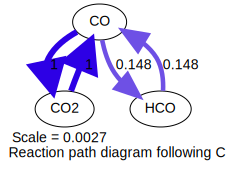

In [14]:
with open(dot_file) as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [15]:
# Filter reactions, keeping only those that only involve the selected species
a = 'HCO'
b = 'CO'
for rnet,R, in zip(gas.net_rates_of_progress,gas.reactions()):
    if not (a in R.reactants and b in R.products) and not (b in R.reactants and a in R.products):
        continue

    print(rnet, R.equation)

-2.79102286589e-20 HCO + O <=> CO + OH
-4.25368289879e-14 H + HCO <=> CO + H2
-1.33000363952e-15 HCO + OH <=> CO + H2O
-4.63112174707e-20 CH3 + HCO <=> CH4 + CO
2.8879134327e-14 H2O + HCO <=> CO + H + H2O
1.4354999394e-14 HCO + M <=> CO + H + M
-5.6953249789e-21 HCO + O2 <=> CO + HO2


In [16]:
element = 'H'

diagram = ct.ReactionPathDiagram(gas, element)
diagram.title = 'Reaction path diagram following {0}'.format(element)
diagram.flow_type = 'OneWayFlow'
#diagram.threshold = 1.e-8

dot_file = 'rxnpath.dot'

diagram.write_dot(dot_file)
print("Wrote graphviz input file to '{0}'.".format(os.path.join(os.getcwd(), dot_file)))

Wrote graphviz input file to '/home/ischoegl/Desktop/lsucombustion/ME4443/examples/rxnpath.dot'.


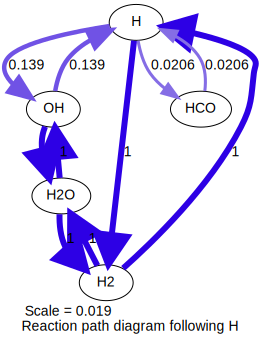

In [17]:
with open(dot_file) as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [18]:
element = 'O'

diagram = ct.ReactionPathDiagram(gas, element)
diagram.title = 'Reaction path diagram following {0}'.format(element)
diagram.flow_type = 'OneWayFlow'
#diagram.threshold = 1.e-8

dot_file = 'rxnpath.dot'

diagram.write_dot(dot_file)
print("Wrote graphviz input file to '{0}'.".format(os.path.join(os.getcwd(), dot_file)))

Wrote graphviz input file to '/home/ischoegl/Desktop/lsucombustion/ME4443/examples/rxnpath.dot'.


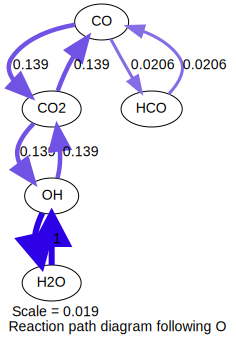

In [19]:
with open(dot_file) as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))